In [112]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from IPython.display import Markdown,display
import datetime
import time
import re
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn import preprocessing
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score




asset_directory = "data/data_asset_choosed/487_None"
file_name = "data/data_asset_choosed/487_None/487_51.csv"
def merge_sing_asset(asset_directory):
    First = True
    for idx,filename in enumerate(os.listdir(asset_directory)):
        name, file_extension = os.path.splitext(asset_directory+"/"+filename)
        if file_extension=='.csv':
            df = pd.read_csv(asset_directory+"/"+filename,parse_dates=[1],na_values=' ')
            if((len(df)>200) & (len(df[np.isnan(df['MDI_OBD_FUEL'])])/len(df)<0.5) & (len(df[np.isnan(df['MDI_OBD_SPEED'])])/len(df)<0.5)):#Condition: file big enough with enough fuel and distance information
                if (First):
                    merged = df
                    First = False
                else:
                    merged = merged.append(df,ignore_index=True)                
    return merged
df_asset = merge_sing_asset(asset_directory)

df_asset.head(10)
len(df_asset)

48163

In [68]:
file_name = "data/data_asset_choosed/487_None/487_51.csv"
df_asset = pd.read_csv(file_name,parse_dates=[1])

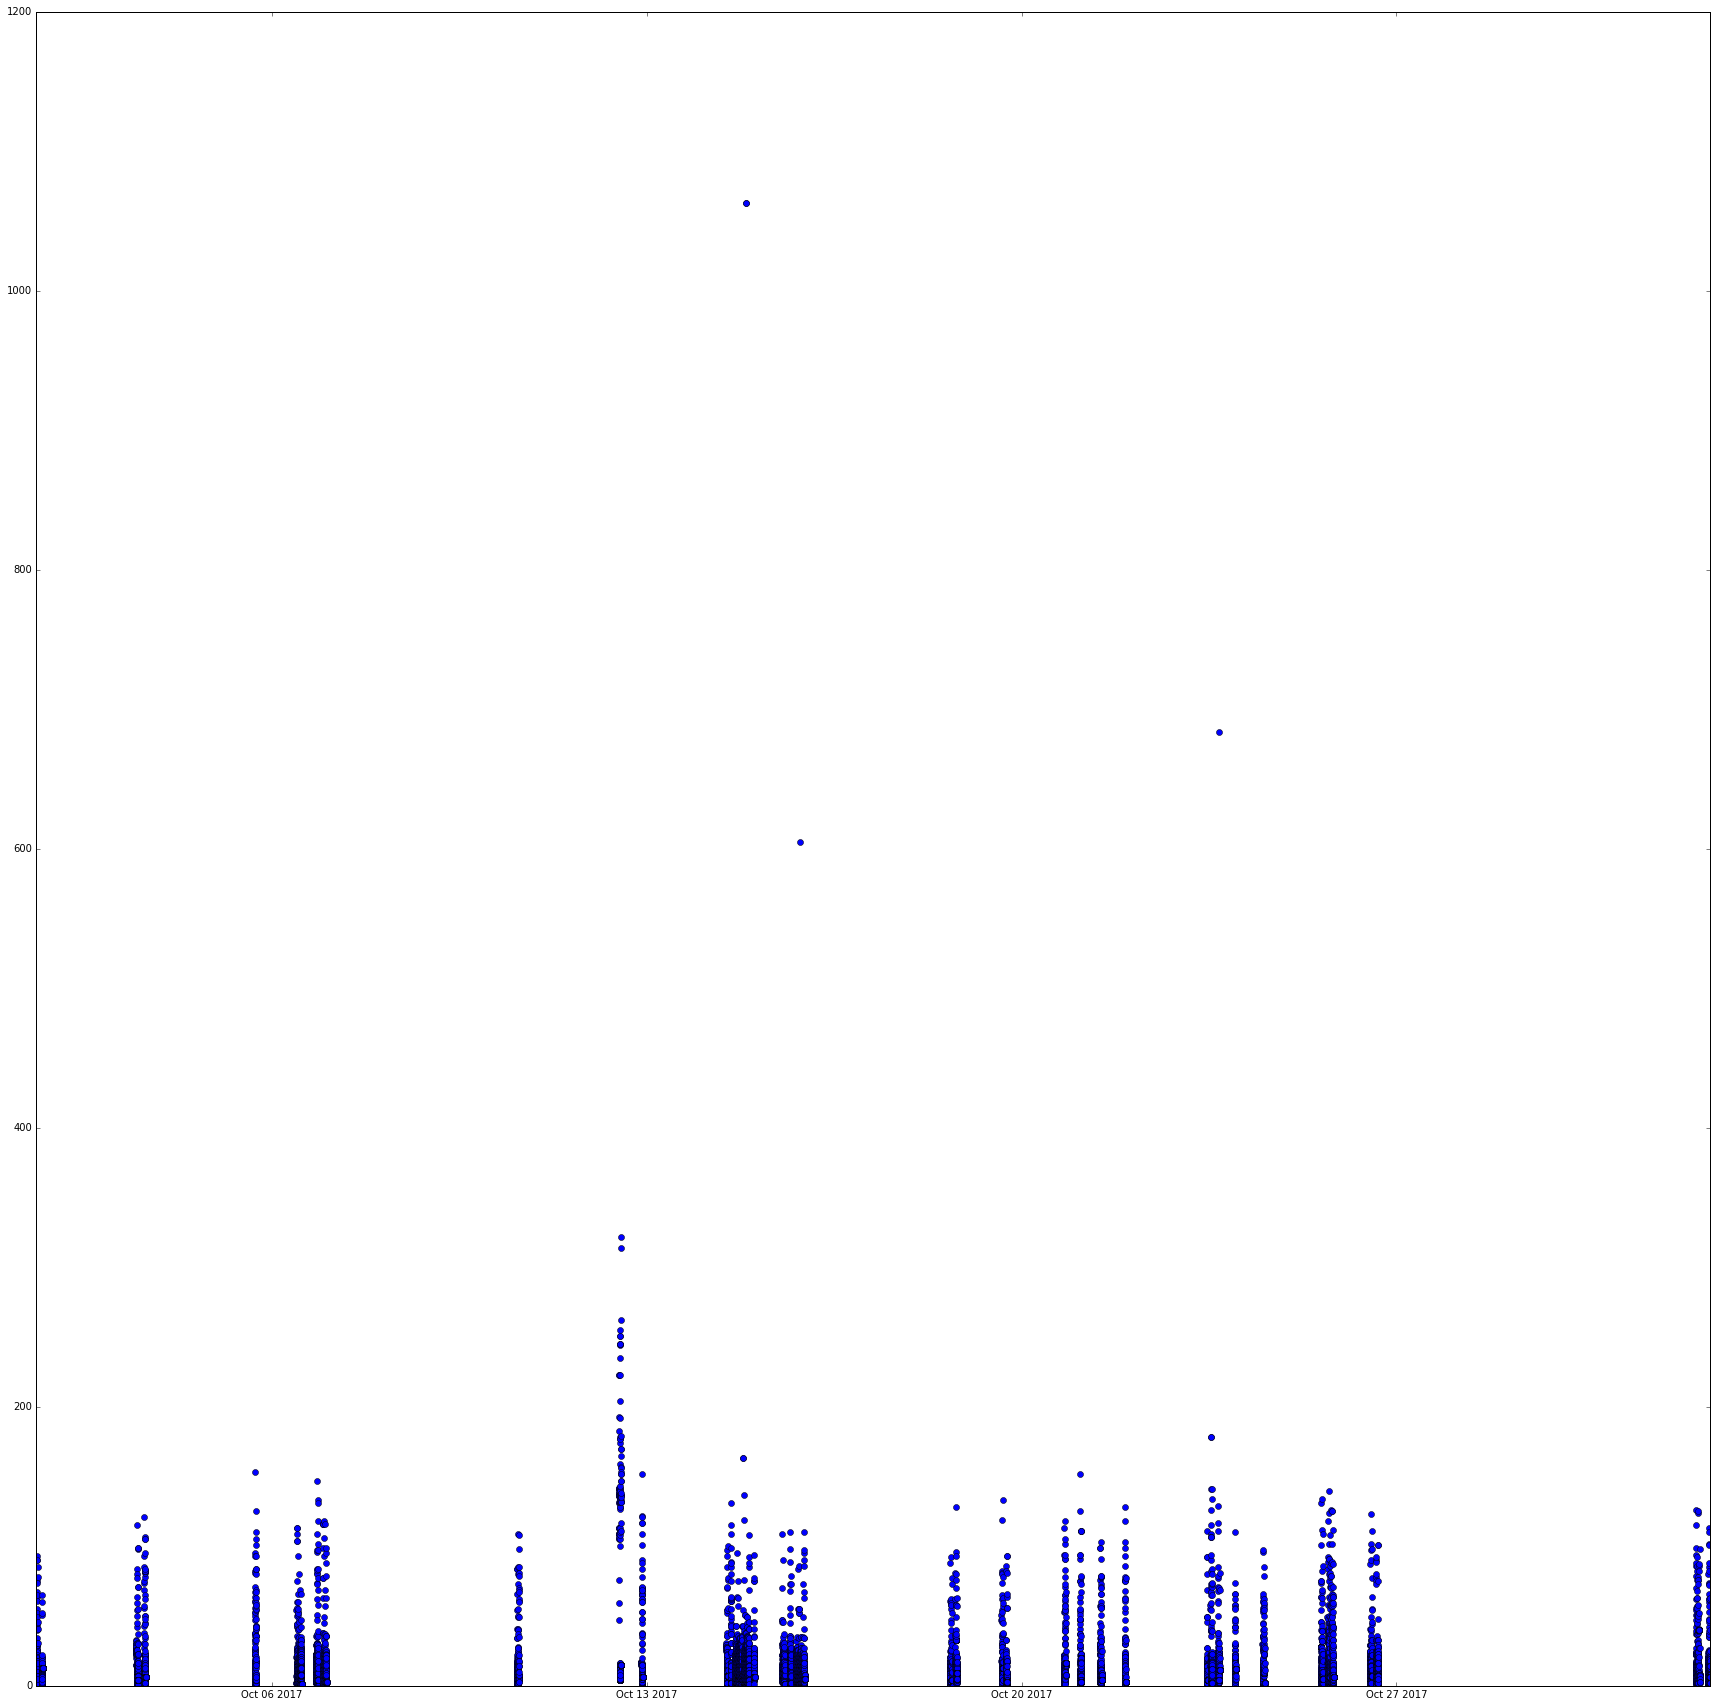

In [113]:
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111)
#ax.plot(df_asset['speed_filled'],df_asset['fuel'], 'o',label="data")
ax.plot(df_asset['recorded_at'],df_asset['fuel'], 'o',label="data")

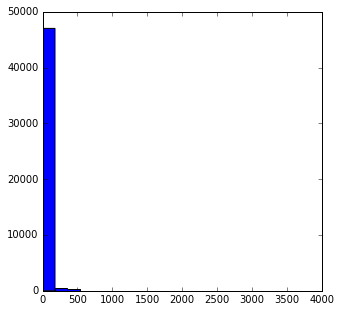

In [114]:
fig = plt.figure(figsize=(5,5))
df_speed = df_asset.loc[~np.isnan(df_asset['distance_speed']),'distance_speed']
plt.hist(df_speed,bins=20)
plt.show()

In [115]:
df_corr = df_asset.drop(['asset','MDI_DASHBOARD_MILEAGE'],axis=1)
df_corr.corr('pearson')['fuel']

MDI_OBD_SPEED         -0.291434
GPS_SPEED             -0.212596
MDI_OBD_RPM           -0.249973
MDI_OBD_ENGINE_LOAD   -0.099237
MDI_OBD_FUEL          -0.040583
ODO_FULL_METER        -0.057752
distance_meter         0.339494
speed_filled          -0.132252
meter_filled          -0.016585
load_filled           -0.152882
rpm_filled            -0.032571
avrg_speed            -0.149288
acceleration          -0.192819
distance_speed         0.663609
distance_cum          -0.024349
delay                  0.393236
fuel                   1.000000
filled_speed          -0.068823
filled_meter          -0.060341
filled_load           -0.296971
filled_rpm            -0.164350
Name: fuel, dtype: float64

In [124]:
#Statsmodel
#With min max scaling
def min_max_format(df):
    min_max_scaler = preprocessing.StandardScaler()
    df = df[~np.isnan(df['MDI_OBD_FUEL']) & ~np.isnan(df['MDI_OBD_SPEED']) ]
    df = df[~np.isnan(df['fuel']) ]
    df = df[np.isfinite(df['distance_speed'])]
    df = df[np.isfinite(df['distance_meter'])]
    time = df['recorded_at']
    speed = pow((df['fuel']+df['distance_meter']+df['distance_speed'])+1,5)
    X = pd.DataFrame(min_max_scaler.fit_transform(df[['distance_speed','delay','distance_meter','MDI_OBD_FUEL']]),index=df.index)
    y = pd.DataFrame(min_max_scaler.fit_transform((df['fuel']).reshape(-1,1)),index=df.index)
    return [y,X,time, speed]

y = min_max_format(df_asset)[0]
X = min_max_format(df_asset)[1]
time = min_max_format(df_asset)[2]
speed = min_max_format(df_asset)[3]
X = sm.add_constant(X)
# Fit model and print summary
rlm_model = sm.RLM(y, X, M=sm.robust.norms.HuberT(),missing='drop')
ols_model = sm.OLS(y,X)
wls_model = sm.WLS(y,X, weights=speed.apply(lambda x: 1/x))

wls_results = wls_model.fit()
ols_results = ols_model.fit()
rlm_results = rlm_model.fit()

print(ols_results.summary())
print(rlm_results.summary())
print(wls_results.summary())


/homes/wsahel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':


                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     5738.
Date:                Fri, 09 Mar 2018   Prob (F-statistic):               0.00
Time:                        21:27:17   Log-Likelihood:                -21908.
No. Observations:               20898   AIC:                         4.383e+04
Df Residuals:                   20893   BIC:                         4.387e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.175e-17      0.005  -6.65e-15      1.0

In [28]:
max(rlm_results.fittedvalues)

6.84696439725582

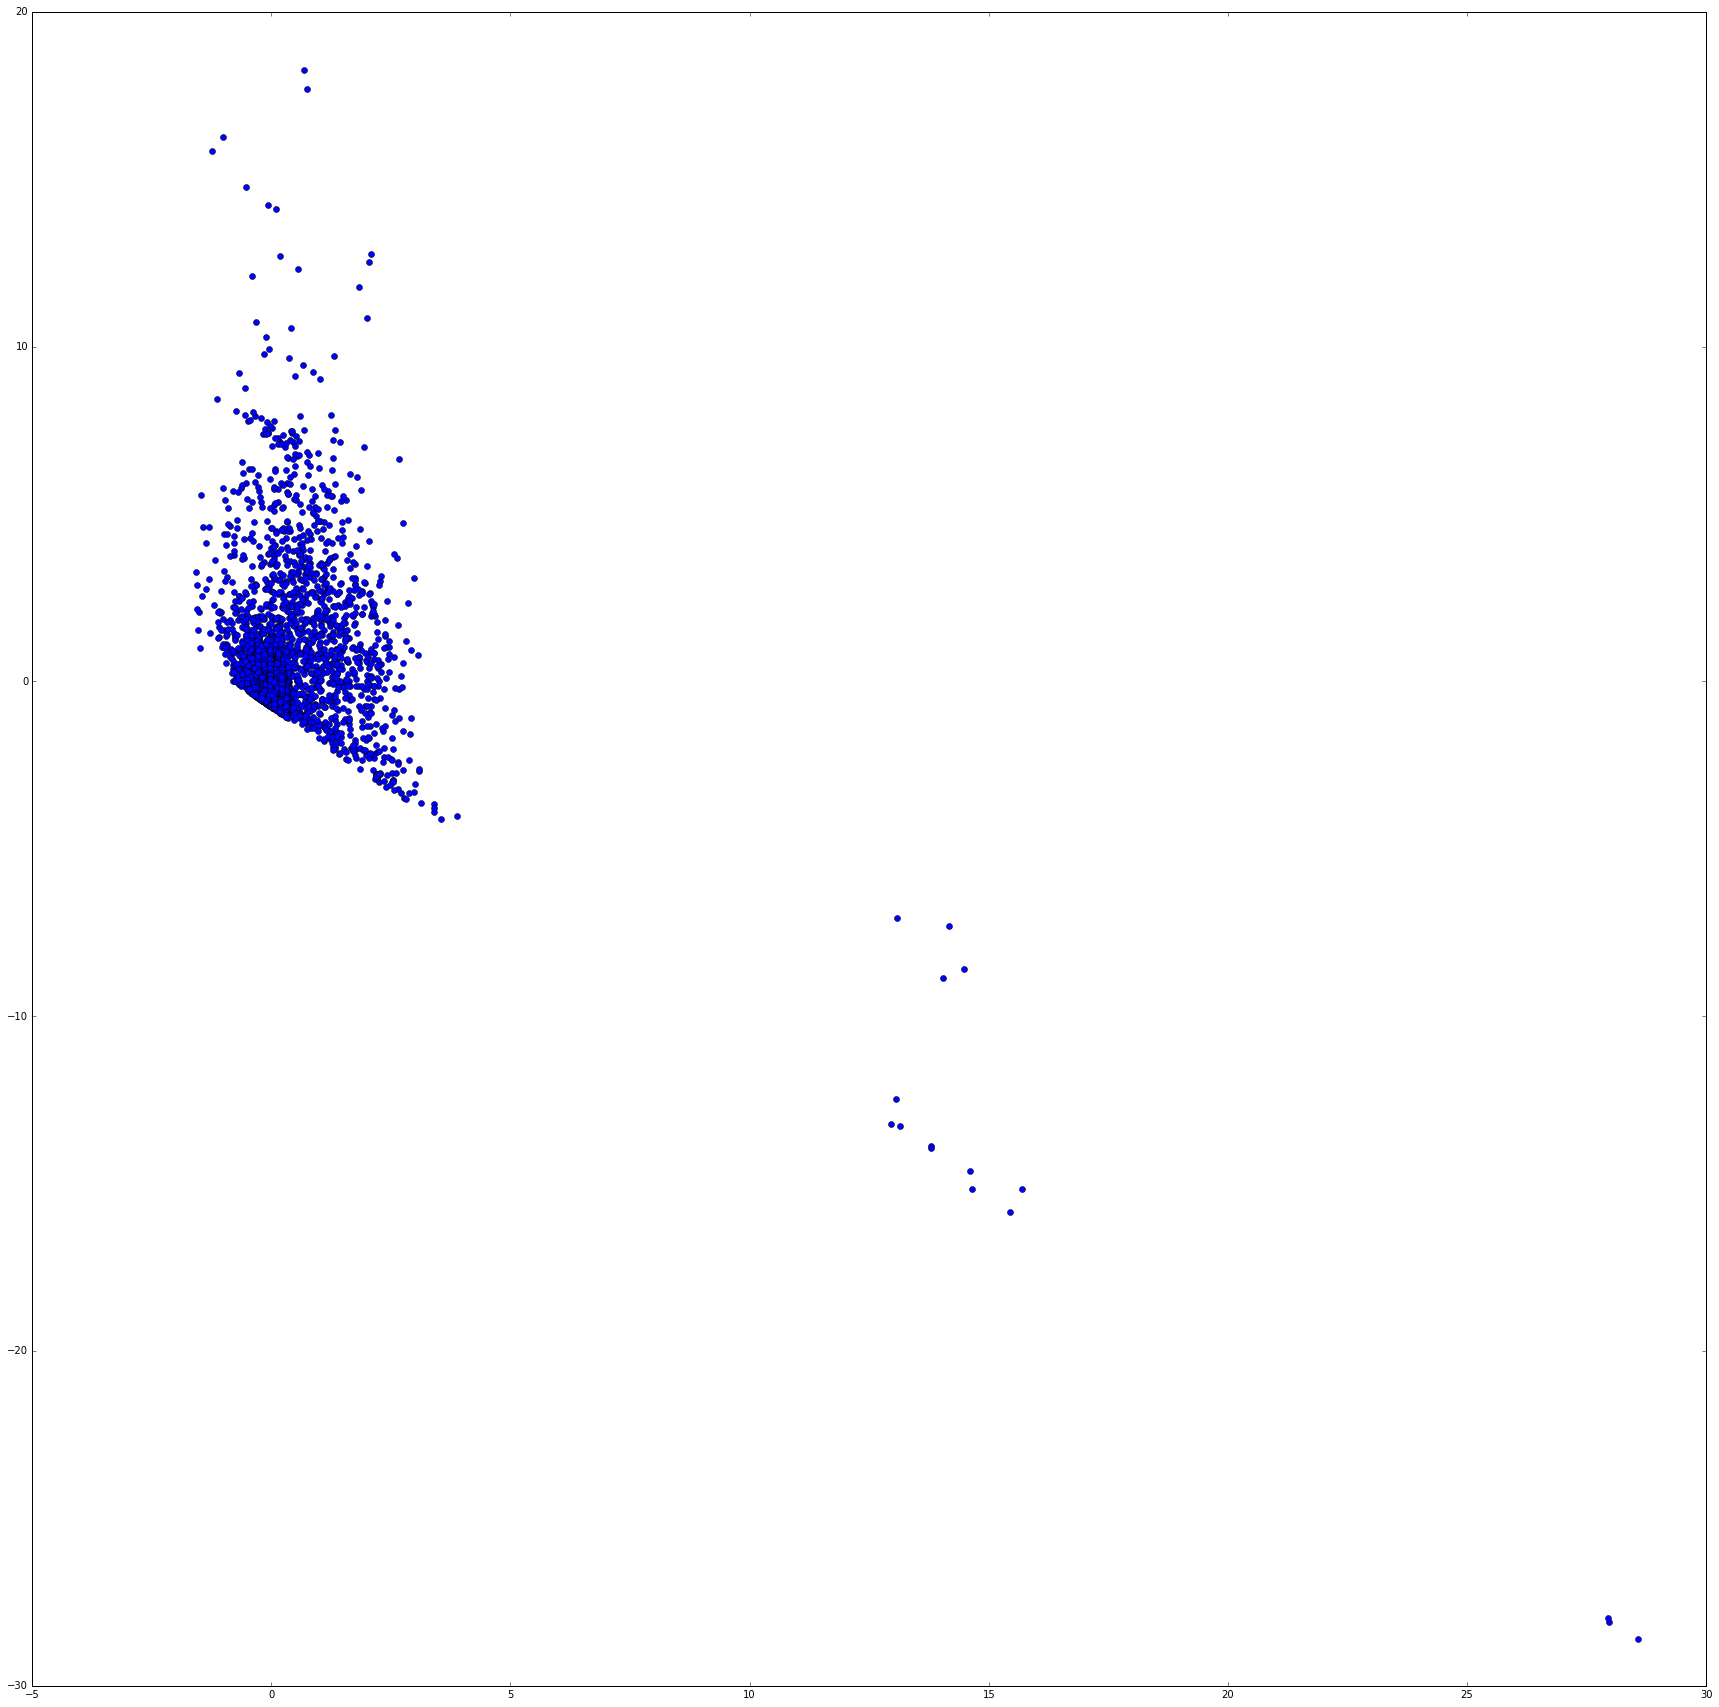

In [131]:
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111)

ax.plot(wls_results.fittedvalues,wls_results.resid, 'o',label="residuals vs fitted")
plt.savefig("regression_fuel_ride_residues_wls")

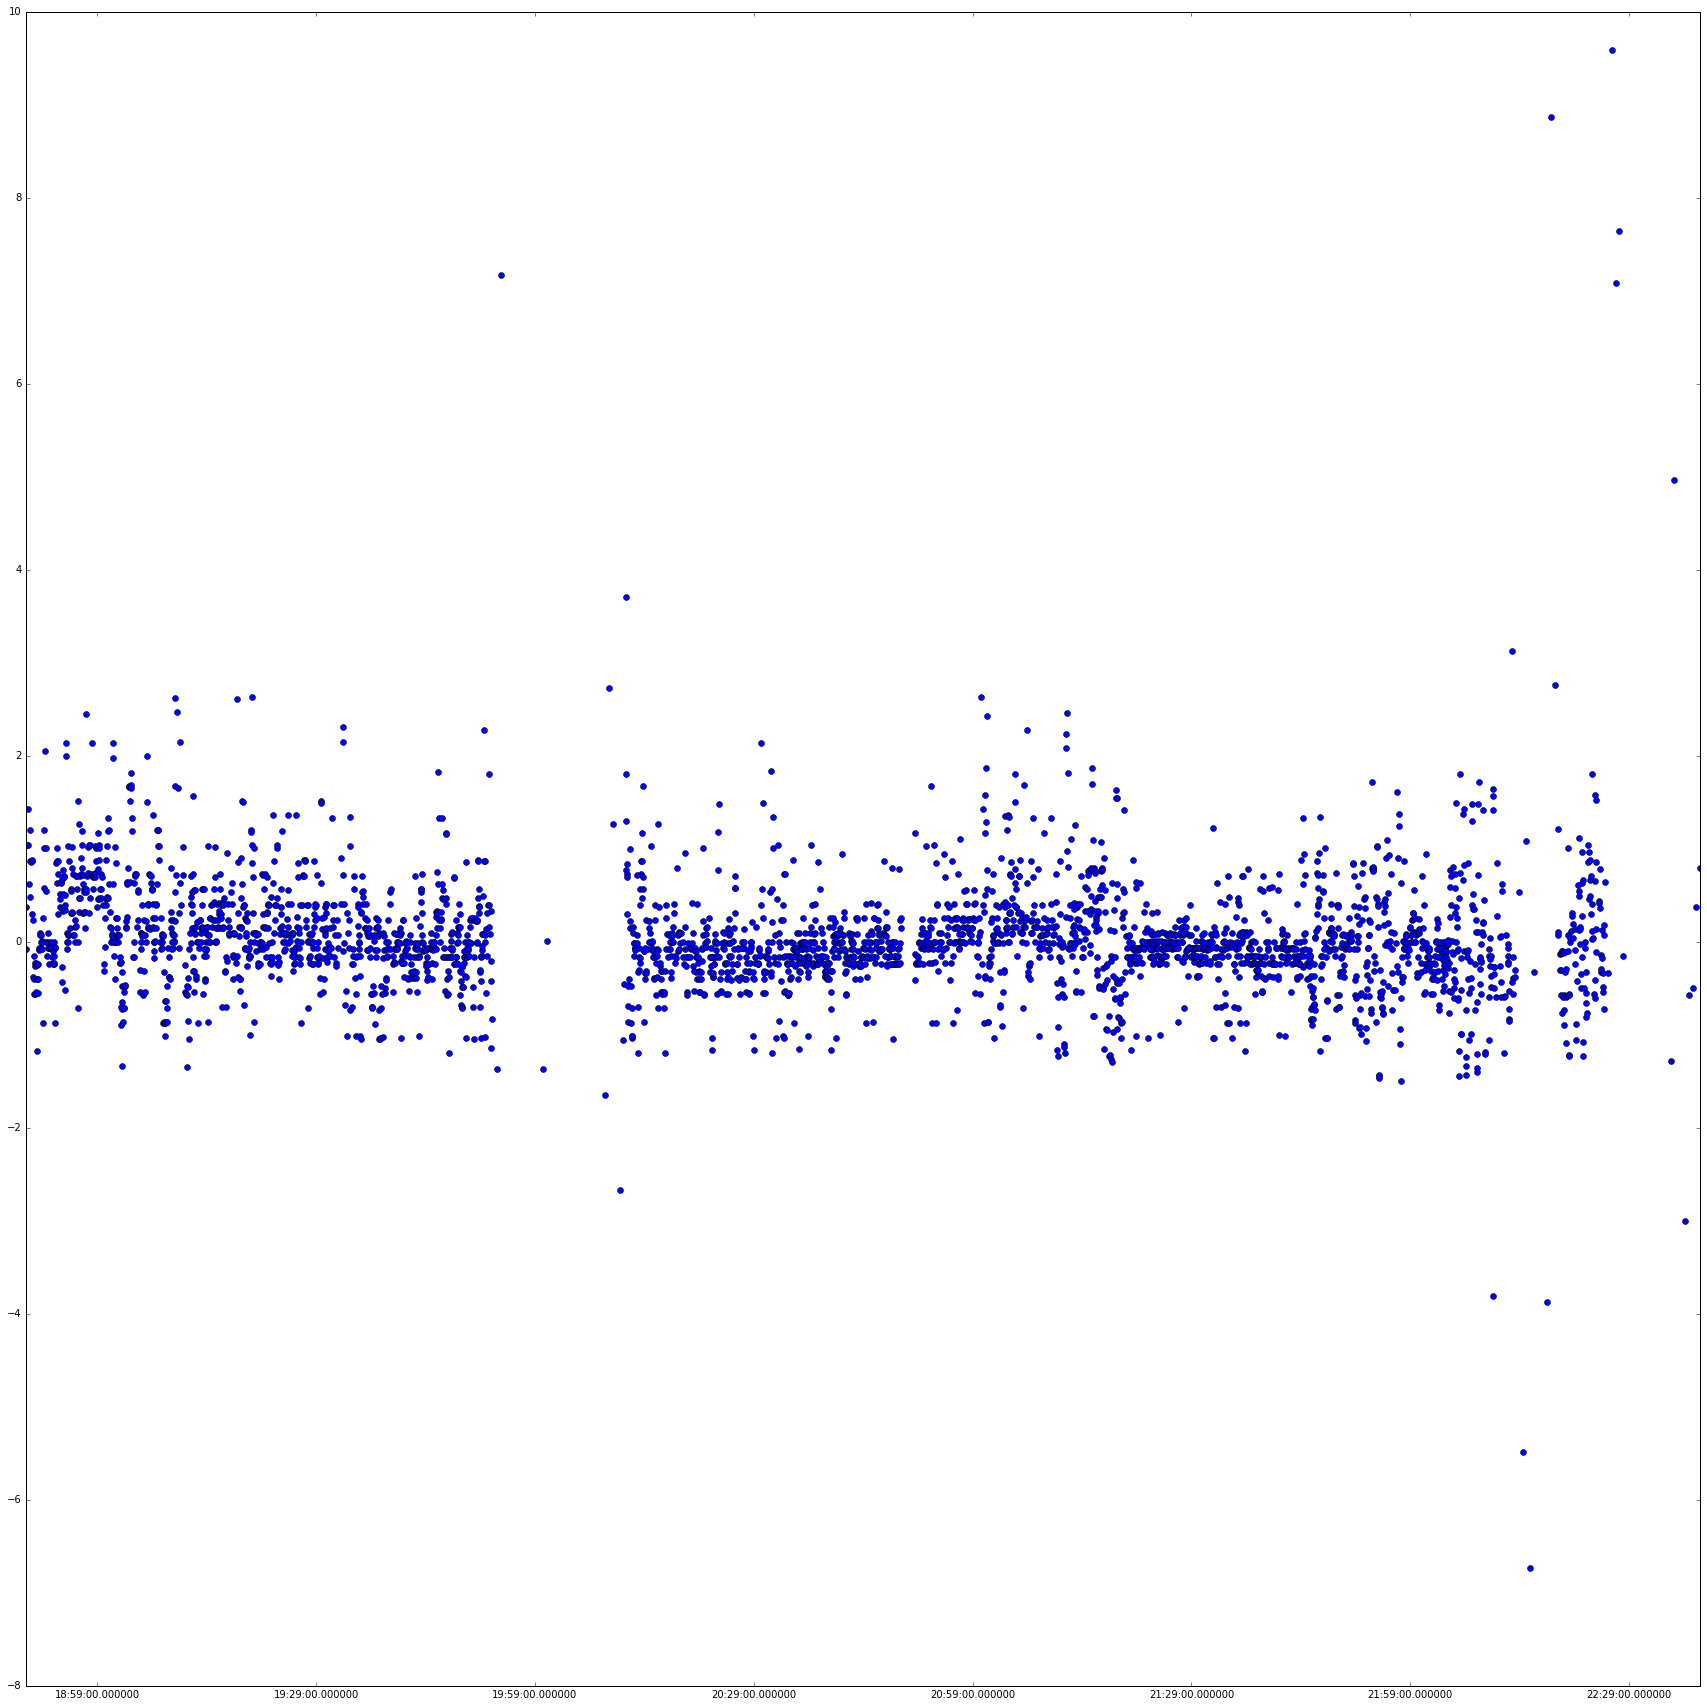

In [99]:
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111)

ax.plot(time,rlm_results.resid, 'o',label="residuals vs fitted")